# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [ ]:
# Requires the latest pip
#!pip install --upgrade pip

# Current stable release for CPU and GPU
#!pip install tensorflow

# Or try the preview build (unstable)
#!pip install tf-nightly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Input, Concatenate
from tensorflow.keras.layers import AveragePooling2D 
from tensorflow.keras.utils import plot_model, to_categorical

In [2]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 
           'лягушка', 'лошадь', 'корабль', 'грузовик']
num_classes = len(classes)

In [3]:
# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочных примеров')
print(x_test.shape[0], 'тестовых примеров')

x_train shape: (50000, 32, 32, 3)
50000 тренировочных примеров
10000 тестовых примеров


In [4]:
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 32,32,3)
x_test = x_test.reshape(x_test.shape[0], 32,32,3)

In [5]:
def compile_model(model):
  # Compile the model
  model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
  )

  return model

In [6]:
batchs = 32
epochs = 5
column_name_result = ['index', 'iteration', 'model_name', 'num_thread', 
                      'num_depth', 'num_core', 'train_metrics', 'valid_metrics']
df_result = pd.DataFrame(columns=column_name_result)

In [7]:
def create_model_standart(x_train, core):
  first_input = Input(shape=x_train.shape[1:])

  x11 = Conv2D(16, core[0], activation='relu', padding = 'same')(first_input)
  first_dense = x11

  x22 = Conv2D(16, core[1], activation='relu', padding = 'same')(first_input)
  second_dense = x22 

  merge_one = Concatenate(axis = -1)([first_dense, second_dense])

  x33 = Conv2D(16, core[2], activation='relu', padding = 'same')(first_input)

  merge_half = Concatenate(axis = -1)([merge_one, x33])
  merge_two = Flatten()(merge_half)
  merge_final = Dense(10, activation='softmax')(merge_two)

  model_stek = Model(inputs=first_input, outputs=merge_final)

  compile_model(model_stek)

  return model_stek

Epoch 1/5
1250/1250 [==============================] - 73s 58ms/step - loss: 1.4860 - accuracy: 0.4818 - val_loss: 1.2763 - val_accuracy: 0.5582
Epoch 2/5
1250/1250 [==============================] - 60s 48ms/step - loss: 1.1456 - accuracy: 0.6026 - val_loss: 1.2291 - val_accuracy: 0.5827
Epoch 3/5
1250/1250 [==============================] - 64s 51ms/step - loss: 0.9974 - accuracy: 0.6568 - val_loss: 1.1910 - val_accuracy: 0.5913
Epoch 4/5
1250/1250 [==============================] - 59s 47ms/step - loss: 0.8756 - accuracy: 0.7003 - val_loss: 1.1829 - val_accuracy: 0.6058
Epoch 5/5
1250/1250 [==============================] - 60s 48ms/step - loss: 0.7600 - accuracy: 0.7392 - val_loss: 1.1751 - val_accuracy: 0.6109
Epoch 1/5
1250/1250 [==============================] - 61s 48ms/step - loss: 1.5239 - accuracy: 0.4734 - val_loss: 1.3036 - val_accuracy: 0.5424
Epoch 2/5
1250/1250 [==============================] - 60s 48ms/step - loss: 1.2023 - accuracy: 0.5829 - val_loss: 1.2383 - val_ac

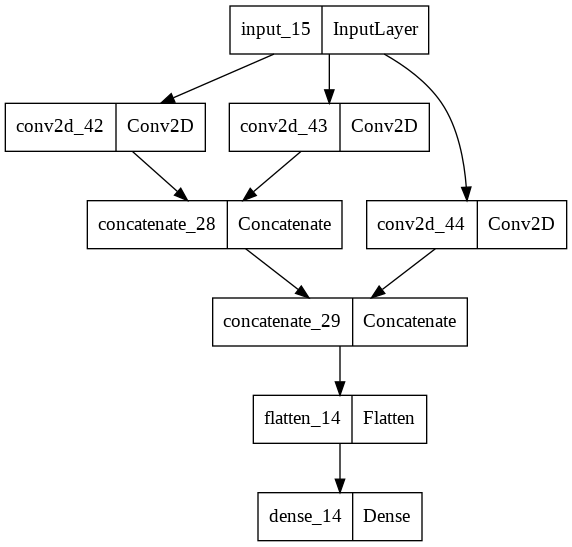

In [8]:
count = 1
core_var = [[3, 3, 3], [5, 5, 5], [1, 1, 1], [2, 2, 1], [4, 3, 2]]

for core in core_var:
  for iteraton in [1, 2, 3]:
    model_stek_standart = create_model_standart(x_train, core)
    with tf.device("GPU:0"):
      history = model_stek_standart.fit(x_train, y_train, epochs = epochs, 
                        batch_size = batchs, validation_split = 0.2)
    dict_result = dict()
    dict_result['index'] = count
    dict_result['iteration'] = iteraton
    dict_result['model_name'] = 'model_standart'
    dict_result['num_thread'] = 3
    dict_result['num_depth'] = 1
    dict_result['num_core'] = str(core)
    dict_result['train_metrics'] = history.history['accuracy'][-1]
    dict_result['valid_metrics'] = history.history['val_accuracy'][-1]
    df_result = pd.concat([df_result, pd.DataFrame(dict_result, index=range(count, count+1))])
    count += 1

plot_model(model_stek_standart, 'model_stek.png')

In [9]:
model_stek_standart.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 16)   784         ['input_15[0][0]']               
                                                                                                  
 conv2d_43 (Conv2D)             (None, 32, 32, 16)   448         ['input_15[0][0]']               
                                                                                                  
 concatenate_28 (Concatenate)   (None, 32, 32, 32)   0           ['conv2d_42[0][0]',              
                                                                  'conv2d_43[0][0]']       

In [10]:
def create_model_thread(x_train, thread):
  first_input = Input(shape=x_train.shape[1:])
  x_thread = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  x1 = Conv2D(16, core[0], activation='relu', padding = 'same')(first_input)
  first_dense = x1

  x2 = Conv2D(16, core[1], activation='relu', padding = 'same')(first_input)
  second_dense = x2 
  x3 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  third_dense = x3 
  x4 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  fourth_dense = x4 
  x5 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  fifth_dense = x5 

  merge_one = Concatenate(axis = -1)([first_dense, second_dense])
  merge_two = Concatenate(axis = -1)([third_dense, fourth_dense])
  merge_three = Concatenate(axis = -1)([merge_one, merge_two])
  merge_four = Concatenate(axis = -1)([merge_three, fifth_dense])

  if thread == 5:
    merge_last = merge_four
    merge_predfinal = Flatten()(merge_last)
    merge_final = Dense(10, activation='softmax')(merge_predfinal)

    model_stek = Model(inputs=first_input, outputs=merge_final)

    compile_model(model_stek)
    return model_stek


  x6 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  sixth_dense = x6 

  x7 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  seventh_dense = x7
  merge_five = Concatenate(axis = -1)([sixth_dense, seventh_dense])
  merge_six = Concatenate(axis = -1)([merge_four, merge_five])

  if thread == 7:
    merge_last = merge_six
    merge_predfinal = Flatten()(merge_last)
    merge_final = Dense(10, activation='softmax')(merge_predfinal)

    model_stek = Model(inputs=first_input, outputs=merge_final)

    compile_model(model_stek)
    return model_stek
  

  x8 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  eighth_dense = x8 

  x9 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  ninth_dense = x9

  x10 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  ninth_dense = x10

  merge_seven = Concatenate(axis = -1)([eighth_dense, ninth_dense])
  merge_eight = Concatenate(axis = -1)([merge_six, merge_seven])
  merge_nine = Concatenate(axis = -1)([merge_eight, ninth_dense])

  if thread == 10:
    merge_last = merge_nine
    merge_predfinal = Flatten()(merge_last)
    merge_final = Dense(10, activation='softmax')(merge_predfinal)

    model_stek = Model(inputs=first_input, outputs=merge_final)

    compile_model(model_stek)
    return model_stek 

Epoch 1/5
1250/1250 [==============================] - 105s 84ms/step - loss: 1.4556 - accuracy: 0.4995 - val_loss: 1.2336 - val_accuracy: 0.5806
Epoch 2/5
1250/1250 [==============================] - 105s 84ms/step - loss: 1.0863 - accuracy: 0.6265 - val_loss: 1.1897 - val_accuracy: 0.5970
Epoch 3/5
1250/1250 [==============================] - 108s 86ms/step - loss: 0.9145 - accuracy: 0.6856 - val_loss: 1.2265 - val_accuracy: 0.5880
Epoch 4/5
1250/1250 [==============================] - 105s 84ms/step - loss: 0.7795 - accuracy: 0.7301 - val_loss: 1.1824 - val_accuracy: 0.6065
Epoch 5/5
1250/1250 [==============================] - 105s 84ms/step - loss: 0.6523 - accuracy: 0.7770 - val_loss: 1.2544 - val_accuracy: 0.6078
Epoch 1/5
1250/1250 [==============================] - 106s 84ms/step - loss: 1.5026 - accuracy: 0.4880 - val_loss: 1.3046 - val_accuracy: 0.5497
Epoch 2/5
1250/1250 [==============================] - 104s 84ms/step - loss: 1.1248 - accuracy: 0.6102 - val_loss: 1.2289 -

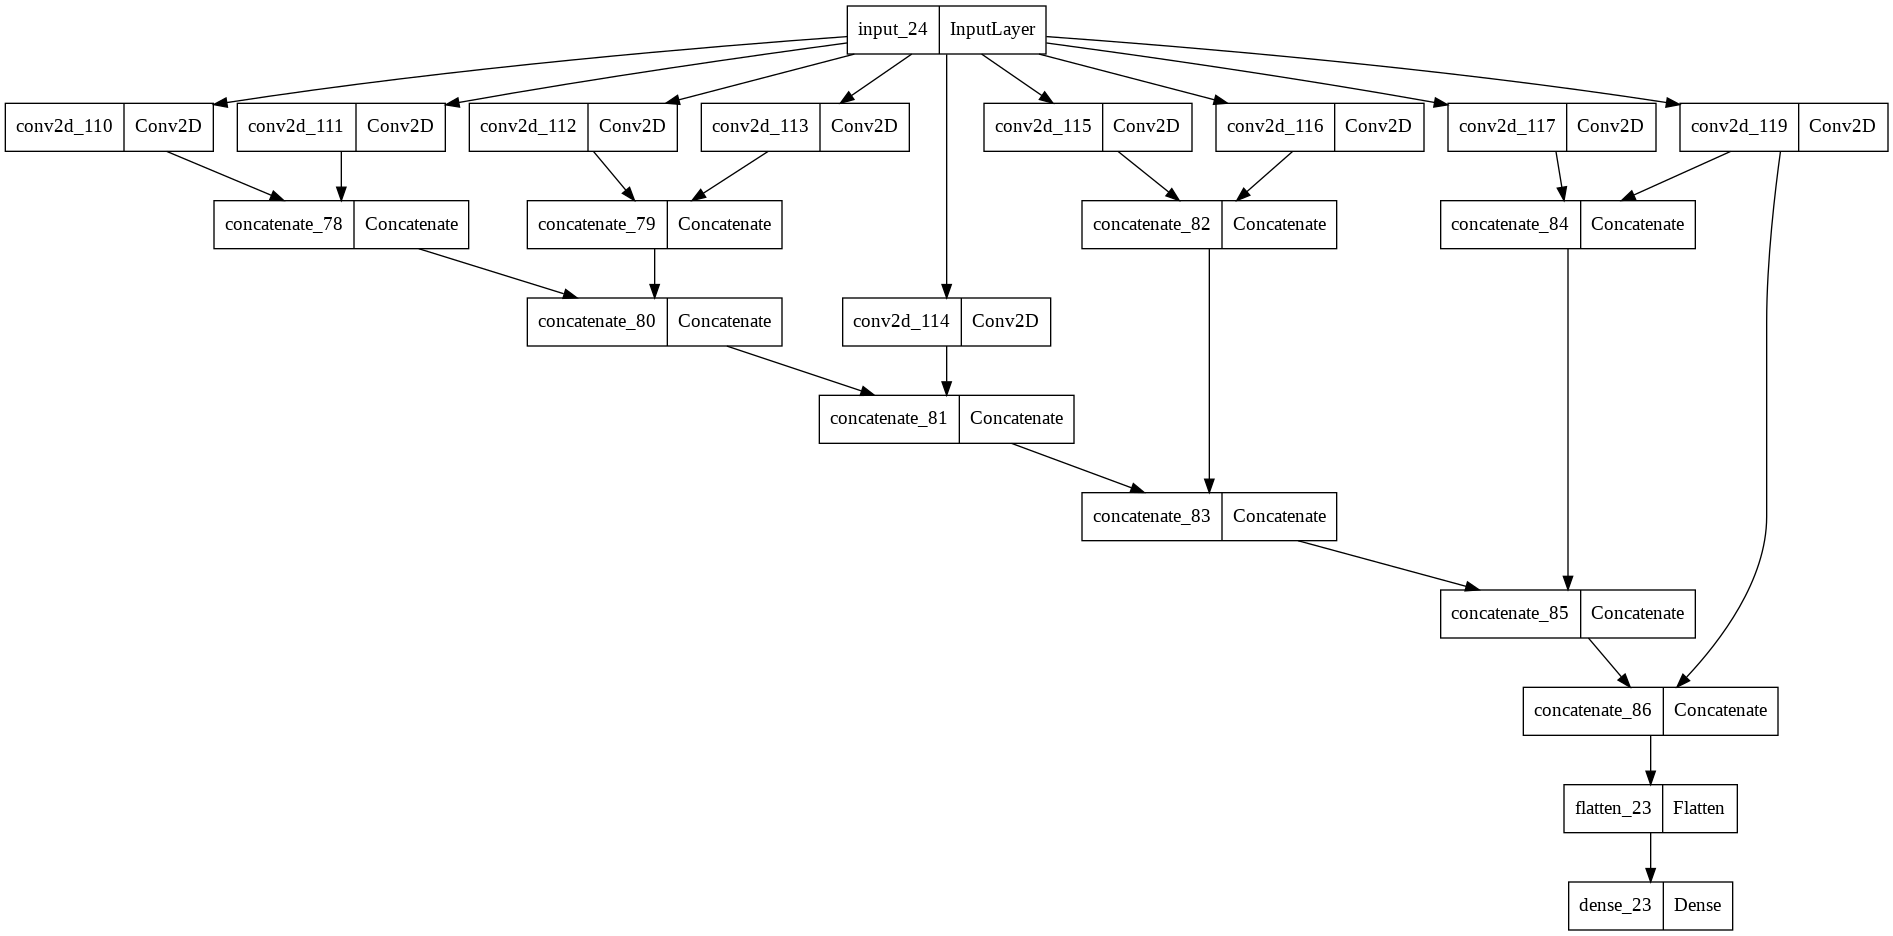

In [11]:
thread_var = [5, 7, 10]

for thread in thread_var:
  for iteraton in [1, 2, 3]:
    model_stek_thread = create_model_thread(x_train, thread)
    with tf.device("GPU:0"):
      history = model_stek_thread.fit(x_train, y_train, epochs = epochs, 
                        batch_size = batchs, validation_split = 0.2)
    dict_result = dict()
    dict_result['index'] = count
    dict_result['iteration'] = iteraton
    dict_result['model_name'] = 'model_stek_more_thread'
    dict_result['num_thread'] = thread
    dict_result['num_depth'] = 1
    dict_result['num_core'] = 3
    dict_result['train_metrics'] = history.history['accuracy'][-1]
    dict_result['valid_metrics'] = history.history['val_accuracy'][-1]
    df_result = pd.concat([df_result, pd.DataFrame(dict_result, index=range(count, count+1))])
    count += 1

plot_model(model_stek_thread, 'model_stek_more_thread.png')

In [12]:
model_stek_thread.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_110 (Conv2D)            (None, 32, 32, 16)   784         ['input_24[0][0]']               
                                                                                                  
 conv2d_111 (Conv2D)            (None, 32, 32, 16)   448         ['input_24[0][0]']               
                                                                                                  
 conv2d_112 (Conv2D)            (None, 32, 32, 16)   448         ['input_24[0][0]']               
                                                                                           

In [13]:
def create_model_layer(x_train, layer):
  first_input = Input(shape=x_train.shape[1:])

  x11 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(16, 3, activation='relu', padding = 'same')(x11)

  x21 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(16, 3, activation='relu', padding = 'same')(x21) 

  x31 = Conv2D(16, 3, activation='relu', padding = 'same')(first_input)
  x32 = Conv2D(16, 3, activation='relu', padding = 'same')(x31)

  if layer == 2:
    first_dense = x12
    second_dense = x22
    third_dense = x32
  else:
    x13 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x12)#Conv2D(16, 3, activation='relu', padding = 'same')(x12)
    x23 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x22)#Conv2D(16, 3, activation='relu', padding = 'same')(x22) 
    x33 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x32)#Conv2D(16, 3, activation='relu', padding = 'same')(x32)
    if layer == 3:
      first_dense = x13
      second_dense = x23
      third_dense = x33
    elif layer == 5:
      x14 = Conv2D(16, 3, activation='relu', padding = 'same')(x13)
      x15 = Conv2D(16, 3, activation='relu', padding = 'same')(x14)
      x24 = Conv2D(16, 3, activation='relu', padding = 'same')(x23)
      x25 = Conv2D(16, 3, activation='relu', padding = 'same')(x24)
      x34 = Conv2D(16, 3, activation='relu', padding = 'same')(x33)
      x35 = Conv2D(16, 3, activation='relu', padding = 'same')(x34)
      first_dense = x15
      second_dense = x25
      third_dense = x35

  merge_one = Concatenate(axis = -1)([first_dense, second_dense])
  merge_half = Concatenate(axis = -1)([merge_one, third_dense])
  merge_two = Flatten()(merge_half)
  merge_final = Dense(10, activation='softmax')(merge_two)

  model_stek_layer = Model(inputs=first_input, outputs=merge_final)

  compile_model(model_stek_layer)

  return model_stek_layer

Epoch 1/5
1250/1250 [==============================] - 171s 136ms/step - loss: 1.4086 - accuracy: 0.5025 - val_loss: 1.1806 - val_accuracy: 0.5935
Epoch 2/5
1250/1250 [==============================] - 169s 135ms/step - loss: 1.0102 - accuracy: 0.6493 - val_loss: 1.0610 - val_accuracy: 0.6274
Epoch 3/5
1250/1250 [==============================] - 169s 135ms/step - loss: 0.8105 - accuracy: 0.7198 - val_loss: 1.0481 - val_accuracy: 0.6422
Epoch 4/5
1250/1250 [==============================] - 169s 135ms/step - loss: 0.6526 - accuracy: 0.7757 - val_loss: 1.0849 - val_accuracy: 0.6416
Epoch 5/5
1250/1250 [==============================] - 168s 134ms/step - loss: 0.5053 - accuracy: 0.8256 - val_loss: 1.1320 - val_accuracy: 0.6452
Epoch 1/5
1250/1250 [==============================] - 169s 135ms/step - loss: 1.3999 - accuracy: 0.5077 - val_loss: 1.1667 - val_accuracy: 0.5939
Epoch 2/5
1250/1250 [==============================] - 168s 134ms/step - loss: 1.0332 - accuracy: 0.6396 - val_loss: 1

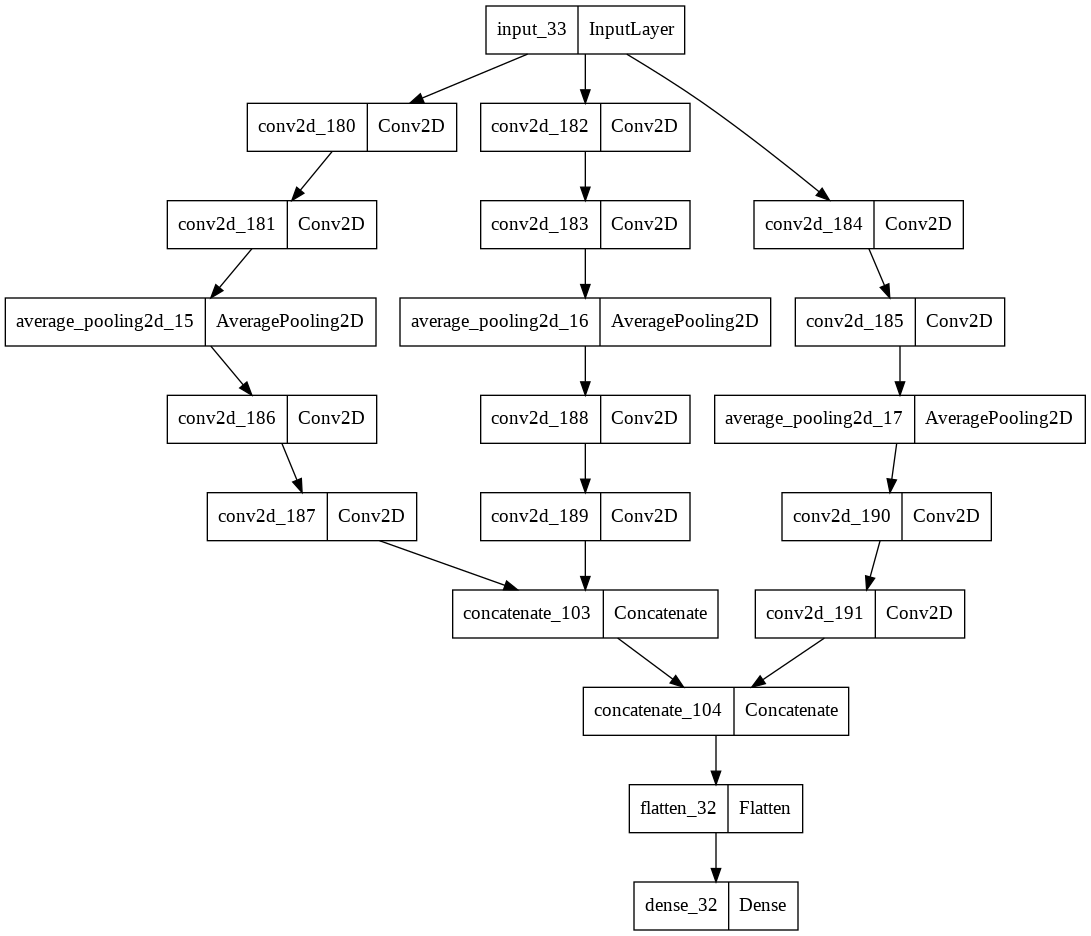

In [14]:
layer_var = [2, 3, 5]
for layer in layer_var:
  for iteraton in [1, 2, 3]:
    model_stek_layer = create_model_layer(x_train, layer)
    with tf.device("GPU:0"):
      history = model_stek_layer.fit(x_train, y_train, epochs = epochs, 
                        batch_size = batchs, validation_split = 0.2)
    dict_result = dict()
    dict_result['index'] = count
    dict_result['iteration'] = iteraton
    dict_result['model_name'] = 'model_stek_more_layer'
    dict_result['num_thread'] = 3
    dict_result['num_depth'] = layer
    dict_result['num_core'] = 3
    dict_result['train_metrics'] = history.history['accuracy'][-1]
    dict_result['valid_metrics'] = history.history['val_accuracy'][-1]
    df_result = pd.concat([df_result, pd.DataFrame(dict_result, index=range(count, count+1))])
    count += 1

plot_model(model_stek_layer, 'model_stek_more_layer.png')

In [15]:
model_stek_layer.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_180 (Conv2D)            (None, 32, 32, 16)   448         ['input_33[0][0]']               
                                                                                                  
 conv2d_182 (Conv2D)            (None, 32, 32, 16)   448         ['input_33[0][0]']               
                                                                                                  
 conv2d_181 (Conv2D)            (None, 32, 32, 16)   2320        ['conv2d_180[0][0]']             
                                                                                           

Epoch 1/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.1023 - accuracy: 0.1907 - val_loss: 2.0793 - val_accuracy: 0.2091
Epoch 2/5
1250/1250 [==============================] - 18s 14ms/step - loss: 2.0108 - accuracy: 0.2427 - val_loss: 2.0342 - val_accuracy: 0.2251
Epoch 3/5
1250/1250 [==============================] - 18s 14ms/step - loss: 1.9754 - accuracy: 0.2569 - val_loss: 1.9684 - val_accuracy: 0.2628
Epoch 4/5
1250/1250 [==============================] - 18s 14ms/step - loss: 1.9628 - accuracy: 0.2687 - val_loss: 1.9537 - val_accuracy: 0.2728
Epoch 5/5
1250/1250 [==============================] - 18s 14ms/step - loss: 1.9434 - accuracy: 0.2796 - val_loss: 1.9373 - val_accuracy: 0.3068
Epoch 1/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.1194 - accuracy: 0.1867 - val_loss: 2.0944 - val_accuracy: 0.2185
Epoch 2/5
1250/1250 [==============================] - 18s 14ms/step - loss: 2.0399 - accuracy: 0.2278 - val_loss: 2.1007 - val_ac

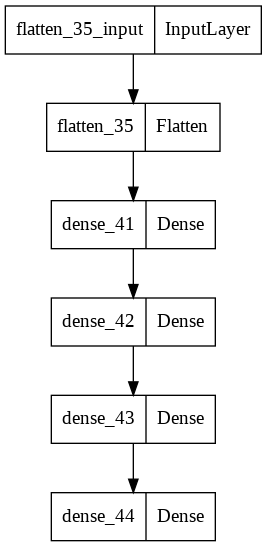

In [16]:
for iteraton in [1, 2, 3]:
  full_connected_network = Sequential([
          Flatten(),
          Dense(512, activation='tanh', input_shape=x_train.shape[1:]),
          Dense(256, activation='tanh'), 
          Dense(128, activation='tanh'), 
          Dense(10, activation='softmax'),
          ])

  compile_model(full_connected_network)
  # full_connected_network.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  with tf.device("GPU:0"):
    history = full_connected_network.fit(x_train, y_train, epochs = epochs,
                              batch_size = batchs, validation_split = 0.2)
  dict_result = dict()
  dict_result['index'] = count
  dict_result['iteration'] = iteraton
  dict_result['model_name'] = 'full_connected_network'
  dict_result['num_thread'] = '-'
  dict_result['num_depth'] = 2
  dict_result['num_core'] = '-'
  dict_result['train_metrics'] = history.history['accuracy'][-1]
  dict_result['valid_metrics'] = history.history['val_accuracy'][-1]
  df_result = pd.concat([df_result, pd.DataFrame(dict_result, index=range(count, count+1))])
  count += 1

plot_model(full_connected_network, 'full_connected_network.png')

In [17]:
df_result

,index,iteration,model_name,num_thread,num_depth,num_core,train_metrics,valid_metrics
1,1,1,model_standart,3,1,"[3, 3, 3]",0.739200,0.6109
2,2,2,model_standart,3,1,"[3, 3, 3]",0.722075,0.5958
3,3,3,model_standart,3,1,"[3, 3, 3]",0.752000,0.6176
4,4,1,model_standart,3,1,"[5, 5, 5]",0.720775,0.5859
5,5,2,model_standart,3,1,"[5, 5, 5]",0.714975,0.5813
6,6,3,model_standart,3,1,"[5, 5, 5]",0.722425,0.5883
7,7,1,model_standart,3,1,"[1, 1, 1]",0.520150,0.4751
8,8,2,model_standart,3,1,"[1, 1, 1]",0.533975,0.4838
9,9,3,model_standart,3,1,"[1, 1, 1]",0.520475,0.4759
10,10,1,model_standart,3,1,"[2, 2, 1]",0.690500,0.5739


Выводы:
1. Полносвязная нейронная сеть показала слабый результат. По метрикам можно сделать вывод, что сеть не переобучена. Необходимо усложнять сеть для получения более качественных предсказаний.
2. При увеличении числа ядер сети наблюдается увеличение качества работы модели.
3. При изменении числа нитей изменения незначительны, явная зависимость качества от числа нитей не прослеживается.  
4. При увеличении числа слоёв сети наблюдается сильное улучшение качества модели, увеличивается точность предсказаний. 